This notebook aims to estimate number of sessions needed from a given mouse to reliably fit HMM-GLM models. The strategy is as follows: 1) fit a model to existing data for a single animal, 2) generate synthetic stimuli sets that are similar to stimuli utilized in the experiments, 3) using this stimuli and the fit model, generate mouse responses, 4) for increasing number of sessions, fit a second HMM-GLM to this generated data to determine how many sessions are required to recapture the model parameters in the second HMM-GLM that were used in the original, generative model.

The code in the notebook was adapted from a notebook prepared by Zoe Ashwood in support of the Ashwood et al. (2020) publication "Mice alternate between discrete strategies during perceptual decision-making".

In [1]:
from uobrainflex.nwb import loadbehavior as load
from uobrainflex.behavioranalysis import flex_hmm
import ssm
from ssm.util import one_hot, find_permutation
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import KFold

In [2]:
#helper functions
# Plot generative parameters:
def plotModelParams(map_glmhmm):
    params = map_glmhmm.observations.params
    fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(1, 2, 1)
    cols = ['#ff7f00', '#4daf4a', '#377eb8', '#7E37B8']
    for k in range(num_states):
        plt.plot(range(input_dim), params[k,:][0]*-1, marker='o',
                 color=cols[k], linestyle='-',
                 lw=1.5, label="state " + str(k+1))
    plt.yticks(fontsize=10)
    plt.ylabel("GLM weight", fontsize=15)
    plt.xlabel("covariate", fontsize=15)
    plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
    plt.axhline(y=0, color="k", alpha=0.5, ls="--")
    plt.legend()
    plt.title("Generative weights", fontsize = 15)

    plt.subplot(1, 2, 2)
    gen_trans_mat = np.exp(map_glmhmm.transitions.log_Ps)
    plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
    for i in range(gen_trans_mat.shape[0]):
        for j in range(gen_trans_mat.shape[1]):
            text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                            color="k", fontsize=12)
    plt.xlim(-0.5, num_states - 0.5)
    plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
    plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
    plt.ylim(num_states - 0.5, -0.5)
    plt.ylabel("state t", fontsize = 15)
    plt.xlabel("state t+1", fontsize = 15)
    plt.title("Generative transition matrix", fontsize = 15)

In [25]:
#get model data
subject='BW016'
sessions=[]
for fileID in range(20210421,20210428):
    this_session = load.get_file_path(subject,str(fileID))
    if this_session:
        sessions.append(this_session)

inpts=list([])
true_choices=list([])
sessions_trial_start =list([])
sessions_response_inds = list([])
for sess in sessions:
    trial_data, trial_labels = load.load_trial_data(sess)
    these_inpts, these_true_choices, trial_start, response_inds = flex_hmm.format_choice_behavior_hmm(trial_data, trial_labels)
    inpts.extend(these_inpts)
    true_choices.extend([these_true_choices])
    sessions_trial_start.extend([trial_start])
    sessions_response_inds.extend([response_inds])

/Users/danielburnham/opt/anaconda3/envs/uobrainflex/lib/python3.6/site-packages/hdmf/spec/namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.2.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/Users/danielburnham/opt/anaconda3/envs/uobrainflex/lib/python3.6/site-packages/hdmf/spec/namespace.py:533: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.3.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


In [26]:
# Set the parameters of the GLM-HMM
num_states = 3        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

###### Fit GLM-HMM with MAP estimation:
# Instantiate GLM-HMM and set prior hyperparameters (MAP version)
prior_sigma = 2
prior_alpha = 2

map_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                     observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                     transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

N_iters = 200
fit_map_ll = map_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters,
                            tolerance=10**-4)

  0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Generative transition matrix')

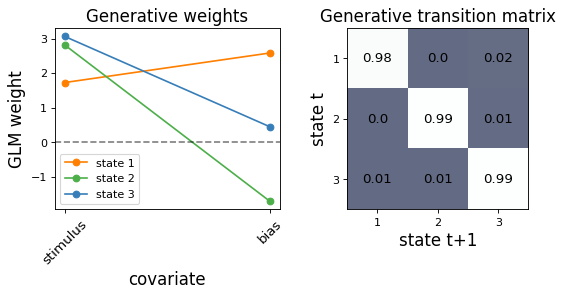

In [27]:
# Plot generative parameters:
params = map_glmhmm.observations.params
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
cols = ['#ff7f00', '#4daf4a', '#377eb8', '#7E37B8']
for k in range(num_states):
    plt.plot(range(input_dim), params[k,:][0]*-1, marker='o',
             color=cols[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Generative weights", fontsize = 15)

plt.subplot(1, 2, 2)
gen_trans_mat = np.exp(map_glmhmm.transitions.log_Ps)
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix", fontsize = 15)

In [6]:
#Simulate an example set of external inputs for each trial in a session.
num_sess = 10 # number of example sessions
num_trials_per_sess = 500 # number of trials in a session
inpts = np.ones((num_sess, num_trials_per_sess, input_dim)) # initialize inpts array
stim_vals = [-.98,-.75,-.62,.62,.75,.98]
inpts[:,:,0] = np.random.choice(stim_vals, (num_sess, num_trials_per_sess)) # generate random sequence of stimuli
inpts = list(inpts) #convert inpts to correct format

In [7]:
# Generate a sequence of latents and choices for each session
true_latents, true_choices = [], []
for sess in range(num_sess):
    true_z, true_y = map_glmhmm.sample(num_trials_per_sess, input=inpts[sess])
    true_latents.append(true_z)
    true_choices.append(true_y)
    
# Calculate true loglikelihood
true_ll = map_glmhmm.log_probability(true_choices, inputs=inpts) 
print("true ll = " + str(true_ll))

true ll = -1872.052261333552


In [8]:
#instantiate a new GLM-HMM
new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                     observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                     transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

#it new GLM-HMM with MAP estimation:
N_iters = 200
new_fit_map_ll = new_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters,
                            tolerance=10**-4)

#first need to permute the states of the fit GLM-HMM relative to the generative model.
new_glmhmm.permute(find_permutation(true_latents[0], new_glmhmm.most_likely_states(true_choices[0], input=inpts[0])))

  0%|          | 0/200 [00:00<?, ?it/s]

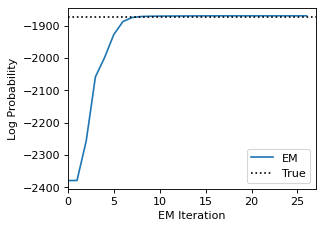

In [9]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(new_fit_map_ll, label="EM")
plt.plot([0, len(new_fit_map_ll)], true_ll * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(new_fit_map_ll))
plt.ylabel("Log Probability")
plt.show()

Text(0.5, 1.0, 'Weight recovery')

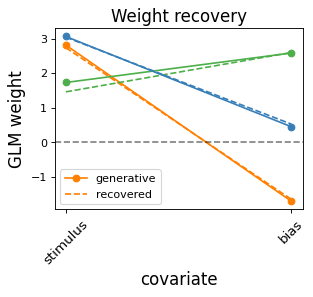

In [10]:
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8']
recovered_weights = new_glmhmm.observations.params
for k in range(num_states):
    if k ==0:
        plt.plot(range(input_dim), params[k,:][0]*-1, marker='o',
                 color=cols[k], linestyle='-',
                 lw=1.5, label="generative")
        plt.plot(range(input_dim), recovered_weights[k,:][0]*-1, color=cols[k],
                     lw=1.5,  label = "recovered", linestyle = '--')
    else:
        plt.plot(range(input_dim), params[k,:][0]*-1, marker='o',
                 color=cols[k], linestyle='-',
                 lw=1.5, label="")
        plt.plot(range(input_dim), recovered_weights[k,:][0]*-1, color=cols[k],
                     lw=1.5,  label = '', linestyle = '--')

plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Weight recovery", fontsize=15)

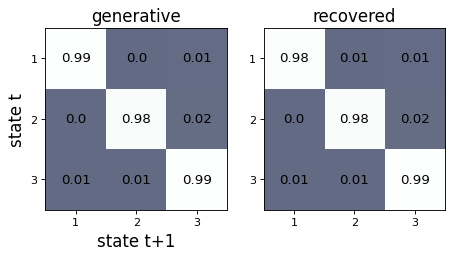

In [11]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
gen_trans_mat = np.exp(map_glmhmm.transitions.log_Ps)
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("generative", fontsize = 15)


plt.subplot(1, 2, 2)
recovered_trans_mat = np.exp(new_glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)

Create 10 ground truth models by 1st taking real experimental results and fitting glm-hmm models to get a distribution of realistic model parameters. Second bootstrap sample these parameter distributions to generate 10 realistic ground truth models.

/Users/danielburnham/opt/anaconda3/envs/uobrainflex/lib/python3.6/site-packages/hdmf/spec/namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.2.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/Users/danielburnham/opt/anaconda3/envs/uobrainflex/lib/python3.6/site-packages/hdmf/spec/namespace.py:533: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.3.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

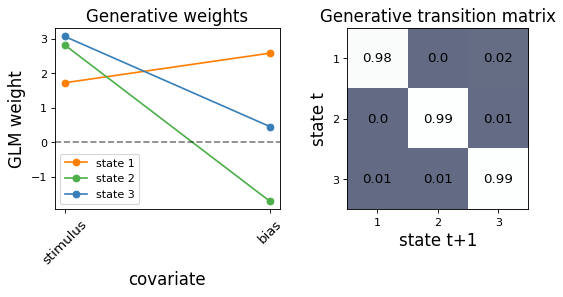

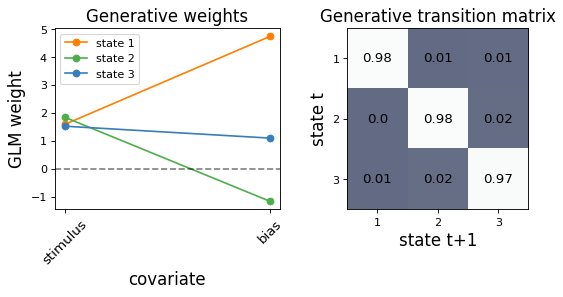

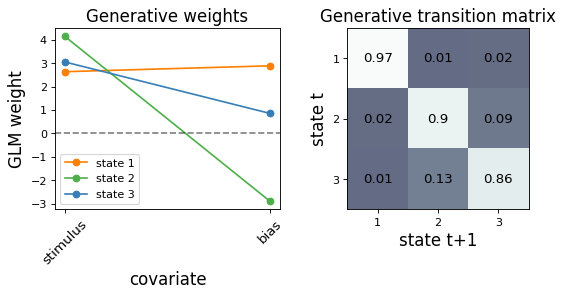

In [5]:
#create 10 ground truth models similar to mouse data
#dictionary of subject IDs and date ranges for mice in S5 training stage of 
#auditory task run by dhulsey
#
dhulsey_s5_aud = {'BW016': (20210421,20210428),
                  'BW031': (20210910, 20210915),
                  'BW045': (20210909, 20210913)}

model_dict = {}
param_dict = {}
for subject in dhulsey_s5_aud.keys():#for each mouse ID in dict of subjects fit a GLM-HMM
    ######Get the Data#######
    sessions=[]
    date_start = dhulsey_s5_aud[subject][0]
    date_end = dhulsey_s5_aud[subject][1]
    for fileID in range(date_start, date_end):
        this_session = load.get_file_path(subject,str(fileID))
        if this_session:
            sessions.append(this_session)

    inpts=list([])
    true_choices=list([])
    sessions_trial_start =list([])
    sessions_response_inds = list([])
    for sess in sessions:
        trial_data, trial_labels = load.load_trial_data(sess)
        these_inpts, these_true_choices, trial_start, response_inds = flex_hmm.format_choice_behavior_hmm(trial_data, trial_labels)
        inpts.extend(these_inpts)
        true_choices.extend([these_true_choices])
        sessions_trial_start.extend([trial_start])
        sessions_response_inds.extend([response_inds])
        
    ####Fit GLM-HMM
    # Set the parameters of the GLM-HMM
    num_states = 3        # number of discrete states
    obs_dim = 1           # number of observed dimensions
    num_categories = 2    # number of categories for output
    input_dim = 2         # input dimensions

    ###### Fit GLM-HMM with MAP estimation:
    # Instantiate GLM-HMM and set prior hyperparameters (MAP version)
    prior_sigma = 2
    prior_alpha = 2

    sub_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                         observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                         transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

    N_iters = 200
    fit_sub_ll = sub_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters,
                                tolerance=10**-4)
    
    if subject == list(dhulsey_s5_aud.keys())[0]:#check if this isnt the first subject
        first_glmhmm = sub_glmhmm
    else:
        # Generate a sequence of latents and choices for each session
        true_latents, true_choices = [], []
        for sess in range(len(sessions)):
            num_trials_per_sess = len(inpts[sess])
            true_z, true_y = first_glmhmm.sample(num_trials_per_sess, input=inpts[sess])
            true_latents.append(true_z)
            true_choices.append(true_y)
        
        sub_glmhmm.permute(find_permutation(np.hstack(true_latents), sub_glmhmm.most_likely_states(np.vstack(true_choices), input=np.vstack(inpts))))
    
    plotModelParams(sub_glmhmm)
    model_dict[subject] = sub_glmhmm#add GLM-HMM model to dictionary of all fit GLM-HMMs
    param_dict[subject] = {'GLM_weights': sub_glmhmm.observations.params, 
                           'HMM_probs': sub_glmhmm.transitions.log_Ps}



In [30]:
#Bootstrap sample the parameter distributions
grnd_truth_N = 10
flat_param_arrays = []
for subject in param_dict.keys():
    subject_params = []
    for param_type in param_dict[subject].keys():
        param_array = param_dict[subject][param_type]
        param_array_flat = param_dict[subject][param_type].flatten()
        subject_params.append(param_array_flat)
    subject_params = np.hstack(subject_params)
    flat_param_arrays.append(subject_params)

subject_params = np.stack(flat_param_arrays)
dist_assump = 'uniform'#could also be uniform
new_params = np.empty((grnd_truth_N, subject_params.shape[1]))
for i in range(subject_params.shape[1]):
    p_dat = subject_params[:,i]
    if dist_assump == 'normal':
        p_dat_new = np.random.normal(loc=np.mean(p_dat), scale=np.std(p_dat), size=grnd_truth_N-len(param_dict.keys()))
    elif dist_assump == 'uniform':
        min_i = np.argmin(p_dat)
        max_i = np.argmax(p_dat)
        p_dat_new = np.random.uniform(low=p_dat[min_i], high=p_dat[max_i], size=grnd_truth_N-len(param_dict.keys()))
    #concatenate experimental params and resampled params together
    new_params[:,i] = np.append(p_dat, p_dat_new)

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Generative vs Recovered Parameters Angle')

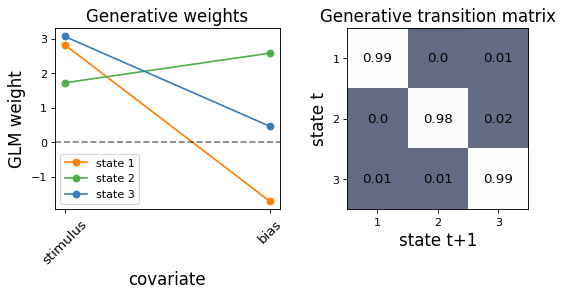

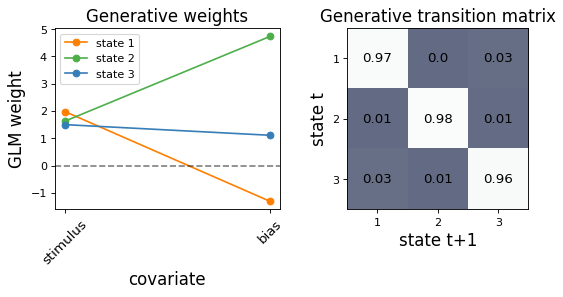

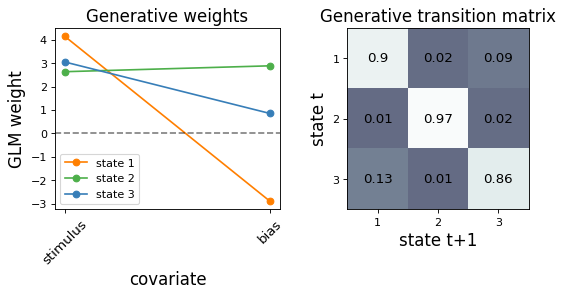

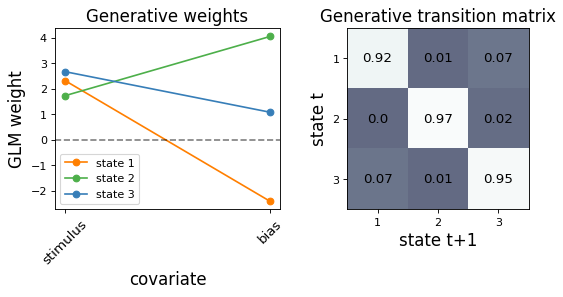

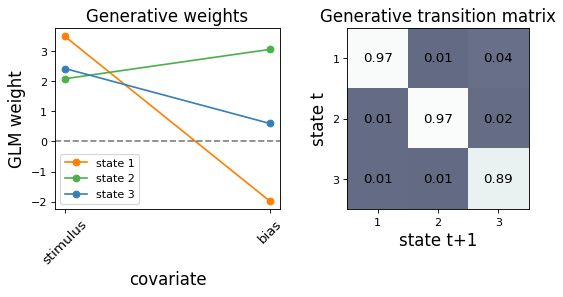

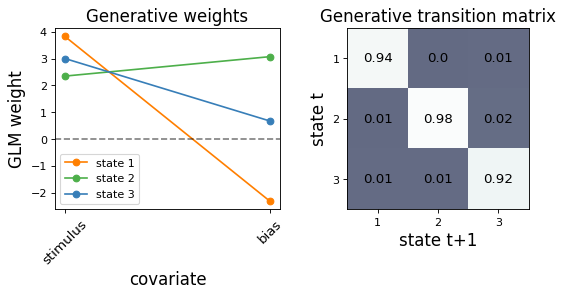

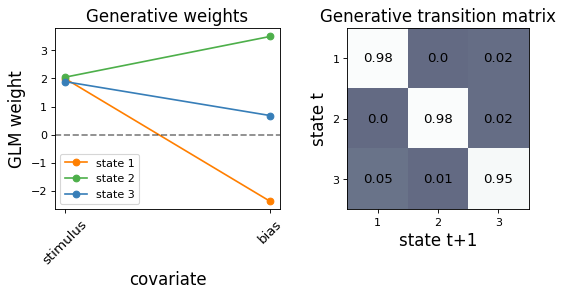

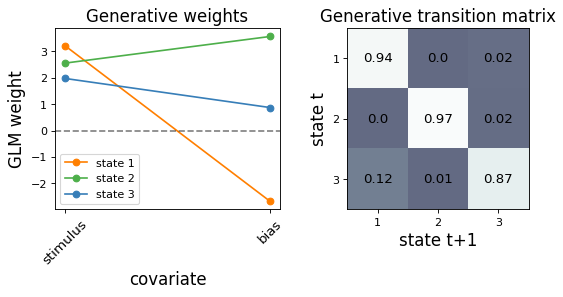

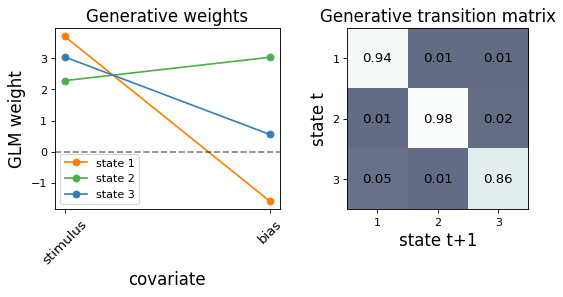

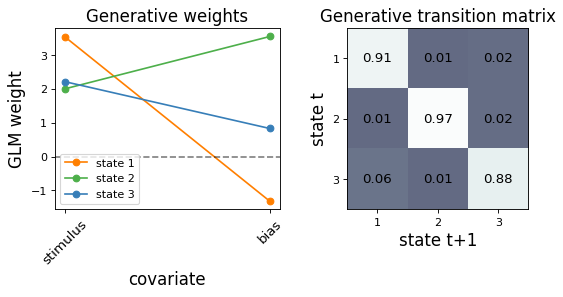

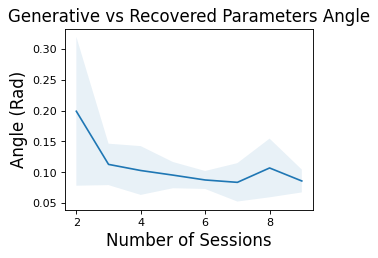

In [15]:
#loop over many different sesion counts and plot L2 distance between the generative model
#parameters and the recovered parameters
num_sess_max = 10
angles = []
#for each ground truth parameter set.. see how many sessions it takes to recover params
for i in range(new_params.shape[0]):
    #initialize ground truth model
    # Set the parameters of the GLM-HMM
    num_states = 3        # number of discrete states
    obs_dim = 1           # number of observed dimensions
    num_categories = 2    # number of categories for output
    input_dim = 2         # input dimensions

    ###### Fit GLM-HMM with MAP estimation:
    # Instantiate GLM-HMM and set prior hyperparameters (MAP version)
    prior_sigma = 2
    prior_alpha = 2

    true_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                         observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                         transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))
    
    gen_weights = new_params[i,:num_states*input_dim].reshape((num_states,1,input_dim))
    gen_log_trans_mat = new_params[i,num_states*input_dim:].reshape((1,num_states,num_states))
    true_glmhmm.observations.params = gen_weights
    true_glmhmm.transitions.params = gen_log_trans_mat
    
    plotModelParams(true_glmhmm)

    subject_angles = []
    for num_sess in range(2, num_sess_max):
        #Simulate an example set of external inputs for each trial in a session.
        num_trials_per_sess = 500 # number of trials in a session
        inpts = np.ones((num_sess, num_trials_per_sess, input_dim)) # initialize inpts array
        stim_vals = [.98,.75,.62,-.62,-.75,-.98]
        inpts[:,:,0] = np.random.choice(stim_vals, (num_sess, num_trials_per_sess)) # generate random sequence of stimuli
        inpts = list(inpts) #convert inpts to correct format

        # Generate a sequence of latents and choices for each session
        true_latents, true_choices = [], []
        for sess in range(num_sess):
            true_z, true_y = true_glmhmm.sample(num_trials_per_sess, input=inpts[sess])
            true_latents.append(true_z)
            true_choices.append(true_y)

        #instantiate a new GLM-HMM
        new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                             observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                             transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

        #it new GLM-HMM with MAP estimation:
        N_iters = 400
        new_fit_map_ll = new_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters,
                                    tolerance=10**-4)

        #first need to permute the states of the fit GLM-HMM relative to the generative model.
        new_glmhmm.permute(find_permutation(np.hstack(true_latents), new_glmhmm.most_likely_states(np.vstack(true_choices), input=np.vstack(inpts))))

        #get generative GLM weights
        generative_weights = true_glmhmm.observations.params.flatten()
        #get recovered GLM weights
        recovered_weights = new_glmhmm.observations.params.flatten()
        #get generative HMM transition matrix
        gen_trans_mat = np.exp(true_glmhmm.transitions.log_Ps).flatten()
        #get recovered HMM transition matrix
        recovered_trans_mat = np.exp(new_glmhmm.transitions.log_Ps).flatten()
        #concatenate recovered parameters into arrays
        gen_stacked_params = np.hstack([generative_weights, gen_trans_mat])
        rec_stacked_params = np.hstack([recovered_weights, recovered_trans_mat])
        #compute L2 distance between arrays of model parameters
        unit_vector_gen = gen_stacked_params / np.linalg.norm(gen_stacked_params)
        unit_vector_rec = rec_stacked_params / np.linalg.norm(rec_stacked_params)
        dot_product = np.dot(unit_vector_gen, unit_vector_rec)
        angle = np.arccos(dot_product)
        subject_angles.append(angle)
    
    angles.append(subject_angles)


start = 2
max_range = num_sess_max
angles = np.vstack(angles)
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
angle_av = np.mean(angles, axis=0)#calculate average angle for each session number                                                                                                                                                 
se = stats.sem(angles, axis=0)#calculate standard error                                                                                                                                                                                     
n = angles.shape[0]                                                                                                                                                                                                       
confidence=0.95                                                                                                                                                                                                           
h = se * stats.t.ppf((1 + confidence) / 2., n-1)                                                                                                                                                                          
angle_top = angle_av + h#find max loss value for each epoch                                                                                                                                                                     
angle_bottom = angle_av - h#find minimum loss value for each epoch                                                                                                                                                                                                                                                                                                                                              
plt.fill_between(range(start, max_range), (angle_bottom), (angle_top), alpha=.1)  
plt.plot(range(start, max_range), angle_av)
plt.yticks(fontsize=10)
plt.ylabel("Angle (Rad)", fontsize=15)
plt.xlabel("Number of Sessions", fontsize=15)
plt.title("Generative vs Recovered Parameters Angle", fontsize=15)

Text(0.5, 1.0, 'Angle Between Generative and Recovered Parameter Vectors')

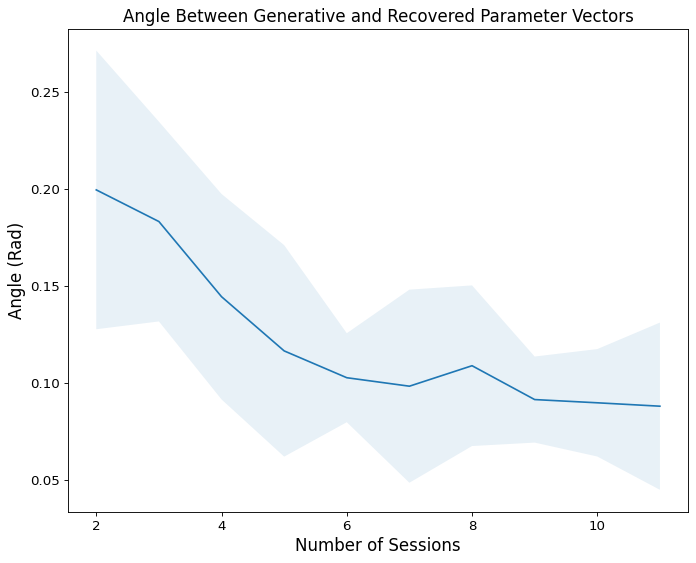

In [24]:
start = 2
max_range = num_sess_max
angles = np.vstack(angles)
fig = plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
angle_av = np.mean(angles, axis=0)#calculate average angle for each session number                                                                                                                                                 
se = stats.sem(angles, axis=0)#calculate standard error                                                                                                                                                                                     
n = angles.shape[0]                                                                                                                                                                                                       
confidence=0.95                                                                                                                                                                                                           
h = se * stats.t.ppf((1 + confidence) / 2., n-1)                                                                                                                                                                          
angle_top = angle_av + h#find max loss value for each epoch                                                                                                                                                                     
angle_bottom = angle_av - h#find minimum loss value for each epoch                                                                                                                                                                                                                                                                                                                                              
plt.fill_between(range(start, max_range), (angle_bottom), (angle_top), alpha=.1)  
plt.plot(range(start, max_range), angle_av)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel("Angle (Rad)", fontsize=15)
plt.xlabel("Number of Sessions", fontsize=15)
plt.title("Angle Between Generative and Recovered Parameter Vectors", fontsize=15)

Now iterate across session count to see how many sessions are needed to recover the original number of states for the model selected through model selection.

(1) Model selection using ground truth/generative models only from the real mice (no synthetic versions), use MLE, MAP, BIC (no K Fold).
(2) Once 3 states is reliably recaptured. Fit synthetically generated data with increasing total session count to estimate how many sessions are needed to recapture parameters.
(3) Repeat these steps for the no choice/3 emission model.

In [108]:
#Model selection functions
#helper functions
#fit model
def fitModel(subject_dict, num_states, obs_dim, num_categories, input_dim):
    #dictionaries to store model parameters
    model_dict = {}
    param_dict = {}
    data_dict = {}
    ######Get the Data#######
    sessions=[]
    subject = list(subject_dict.keys())[0]
    date_start = subject_dict[subject][0]
    date_end = subject_dict[subject][1]
    for fileID in range(date_start, date_end):
        this_session = load.get_file_path(subject,str(fileID))
        if this_session:
            sessions.append(this_session)

    inpts=list([])
    true_choices=list([])
    sessions_trial_start =list([])
    sessions_response_inds = list([])
    for sess in sessions:
        trial_data, trial_labels = load.load_trial_data(sess)
        these_inpts, these_true_choices, trial_start, response_inds = flex_hmm.format_choice_behavior_hmm(trial_data, trial_labels)
        inpts.extend(these_inpts)
        true_choices.extend([these_true_choices])
        sessions_trial_start.extend([trial_start])
        sessions_response_inds.extend([response_inds])

    ####Fit GLM-HMM
    ###### Fit GLM-HMM with MAP estimation:
    # Instantiate GLM-HMM and set prior hyperparameters (MAP version)
    prior_sigma = 2
    prior_alpha = 2

    sub_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                         observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                         transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

    N_iters = 200
    fit_sub_ll = sub_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters,
                                tolerance=10**-4)

    plotModelParams(sub_glmhmm)
    model_dict[subject] = sub_glmhmm#add GLM-HMM model to dictionary of all fit GLM-HMMs
    param_dict[subject] = {'GLM_weights': sub_glmhmm.observations.params, 
                           'HMM_probs': sub_glmhmm.transitions.log_Ps}
    data_dict[subject] = {'inpts': inpts, 
                           'true_choices': true_choices}
    return fit_sub_ll, model_dict, param_dict, data_dict
# Plot generative parameters:
def plotModelParams(map_glmhmm):
    params = map_glmhmm.observations.params
    num_states = params.shape[0]
    input_dim = params.shape[2]
    fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(1, 2, 1)
    cols = ['#ff7f00', '#4daf4a', '#377eb8', '#7E37B8']
    for k in range(num_states):
        plt.plot(range(input_dim), params[k,:][0]*-1, marker='o',
                 color=cols[k], linestyle='-',
                 lw=1.5, label="state " + str(k+1))
    plt.yticks(fontsize=10)
    plt.ylabel("GLM weight", fontsize=15)
    plt.xlabel("covariate", fontsize=15)
    plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
    plt.axhline(y=0, color="k", alpha=0.5, ls="--")
    plt.legend()
    plt.title("Generative weights", fontsize = 15)

    plt.subplot(1, 2, 2)
    gen_trans_mat = np.exp(map_glmhmm.transitions.log_Ps)
    plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
    for i in range(gen_trans_mat.shape[0]):
        for j in range(gen_trans_mat.shape[1]):
            text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                            color="k", fontsize=12)
    plt.xlim(-0.5, num_states - 0.5)
    plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
    plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
    plt.ylim(num_states - 0.5, -0.5)
    plt.ylabel("state t", fontsize = 15)
    plt.xlabel("state t+1", fontsize = 15)
    plt.title("Generative transition matrix", fontsize = 15)

def plotModelBehav(map_glmhmm, inpts, true_choices, title):
    num_states = params = map_glmhmm.observations.params
    num_states = params.shape[0]
    
    cmap = plt.get_cmap("tab10")#get 'tab10' color map to pull indices from to use for plotting individual model results
    c_inds = np.linspace(0.0, 1.0, num=num_states)#grab indices for colors for 7 model types across the range of 'tab10' color values
    cols = cmap(c_inds)#map those indices to a list colors
    
    #plot dwell times
    # Get expected states:
    posterior_probs = [map_glmhmm.expected_states(data=data, input=inpt)[0]
                       for data, inpt
                       in zip(true_choices, inpts)]
    # concatenate posterior probabilities across sessions
    posterior_probs_concat = np.concatenate(posterior_probs)
    # get state with maximum posterior probability at particular trial:
    state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
    # now obtain state fractional occupancies:
    _, state_occupancies = np.unique(state_max_posterior, return_counts=True)
    state_occupancies = state_occupancies/np.sum(state_occupancies)

    #plot
    fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
    for z, occ in enumerate(state_occupancies):
        plt.bar(z, occ, width = 0.8, color = cols[z])
    plt.ylim((0, 1))
    plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
    plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
    plt.xlabel('state', fontsize = 15)
    plt.ylabel('frac. occupancy', fontsize=15)
    plt.title(str(num_states) + 'States, ' + title)
    #plt.savefig("state_occupancy.svg")
    
    #plot psycometric curve
    ### generate psychometrics per state
    #concatenate inpts and choices
    inpts_concat = np.concatenate(inpts)
    trial_inpts = inpts_concat[:,0]
    choice_concat = np.concatenate(true_choices)

    state_inpt_choice = pd.DataFrame(data=[],index=np.unique(state_max_posterior), columns = np.unique(trial_inpts))
    trial_n = pd.DataFrame(data=[],index=np.unique(state_max_posterior), columns = np.unique(trial_inpts))
    for iState in range(0,num_states):
        state_ind = np.where(state_max_posterior == iState)[0].astype(int)
        state_inpts = trial_inpts[state_ind]
        state_choices = choice_concat[state_ind]
        for iInp in np.unique(state_inpts):
            these_trials = np.where(state_inpts == iInp)[0]
            #if iInp > 0:
                #correct_choice = 1
                #mult=1
            #if iInp <0:
                #correct_choice = 0
                #mult=-1
            #state_inpt_choice.loc[iState,iInp] = len(np.where(state_choices[these_trials]==correct_choice)[0])/len(these_trials)*mult
            state_inpt_choice.loc[iState,iInp] = len(np.where(state_choices[these_trials]==1)[0])/len(these_trials)
            trial_n.loc[iState,iInp] =len(these_trials)

    for iInp in np.unique(trial_inpts):
        these_trials = np.where(trial_inpts == iInp)[0]
        state_inpt_choice.loc['all_trials',iInp] = len(np.where(choice_concat[these_trials]==1)[0])/len(these_trials)
        trial_n.loc['all_trials',iInp] = len(these_trials)

    actual_inpts = [-.98, -.63, -.44, .44, .63, .98]
    state_inpt_choice.columns = actual_inpts
    fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
    plt.xlabel('Stimulus')
    plt.ylabel('Right Choice Probability')
    plt.title('Performance by State: ' + title)
    for idx in state_inpt_choice.index:
        if idx == 'all_trials':
            plt.plot(state_inpt_choice.loc[idx,:],'k--',marker='o')
        if idx != 'all_trials':
            plt.plot(state_inpt_choice.loc[idx,:],marker='o', color=cols[idx])   
    #plt.savefig("performance_by_state.svg")
    plt.show()  
    
def makeModel(num_states, obs_dim, num_categories, input_dim,
                               subject_params, plotModel = True):
    """
    Initialize ground truth model for parameter recovery analysis.
    Parameters
    ----------
    num_states : scalar
        number of discrete states.
    obs_dim : scalar
        number of observed dimensions.
    num_categories : scalar
        number of categories for output
    input_dim : scalar
        number of input data dimensions
    Returns
    -------
    true_glmhmm : HMM-GLM model object
        GLM-HMM with MAP estimation object with specified parameters.
    """
    ###### Fit GLM-HMM with MAP estimation:
    # Instantiate GLM-HMM and set prior hyperparameters (MAP version)
    prior_sigma = 2
    prior_alpha = 2

    true_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                         observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                         transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

    true_glmhmm.observations.params = subject_params['GLM_weights']
    true_glmhmm.transitions.params = np.expand_dims(subject_params['HMM_probs'], axis=0)

    if plotModel == True:
        plotModelParams(true_glmhmm)

    return true_glmhmm

def simulateData(true_glmhmm, num_sess, num_trials_per_sess, stim_vals, plot=True):
    """
    Simulate an example set of external inputs for each trial in a session.
    Parameters
    ----------
    true_glmhmm : HMM-GLM model object
        GLM-HMM estimation object to be used to generate synthetic data.
    num_trials_per_sess : scalar
        number of trials in a session.
    stim_vals : list
        stimulus values to be used as input to model for synthetic data generation.
        (e.g. stim_vals = [.98,.75,.62,-.62,-.75,-.98])
    Returns
    -------
    inpts : HMM-GLM model object
        input stimuli used by the model to generate the synthetic choice data
    true_latents : HMM-GLM model object
        latent states of the ground truth model
    true_choices : HMM-GLM model object
        output choices of the ground truth model, i.e. synthetic choice data
    """
    inpts = np.ones((num_sess, num_trials_per_sess, input_dim)) # initialize inpts array
    inpts[:,:,0] = np.random.choice(stim_vals, (num_sess, num_trials_per_sess)) # generate random sequence of stimuli
    inpts = list(inpts) #convert inpts to correct format

    # Generate a sequence of latents and choices for each session
    true_latents, true_choices = [], []
    for sess in range(num_sess):
        true_z, true_y = true_glmhmm.sample(num_trials_per_sess, input=inpts[sess])
        true_latents.append(true_z)
        true_choices.append(true_y)
    if plot == True:
        title = str(num_sess) + ' sessions'
        plotModelBehav(true_glmhmm, inpts, true_choices, title)
    return inpts, true_latents, true_choices

def modelSelectionCV(inpts, true_choices, max_states, nKfold, 
                     obs_dim, input_dim, N_iters=1000, TOL=10**-6, min_states=1):
    """
    Perform K Fold cross validation for model selection.
    Parameters
    ----------
    inpts : HMM-GLM model object
        input stimuli used by the model to generate the synthetic choice data
    true_choices : HMM-GLM model object
        output choices of the ground truth model, i.e. synthetic choice data
    max_states : scalar
        maximum number of states for which to perform model selection.
    nKfold : scalar
        number of cross validation folds
    obs_dim : scalar
        number of observed dimensions.
    input_dim : scalar
        number of input data dimensions
    N_iters : scalar
        maximum number of EM iterations. Fitting with stop earlier 
        if increase in LL is below tolerance specified by tolerance parameter. Default 1000.
    TOL : scalar
        tolerance parameter (see N_iters). Default 10**-6.
    min_states : scalar
        minimum number of states for which to perform model selection. Default 1.
    Returns
    -------
    (ll_training_map, ll_heldout_map) : tuple of np.ndarray's
        tuple containing results for model selection using MAP. 
        The first entry is the model log likelihood for the tested number of states
        on the training data set. The second entry is the mode log likelihood on 
        the test set.
    (ll_training_mle, ll_heldout_mle) : tuple of np.ndarray's
        tuple containing results for model selection using MLE. 
        The first entry is the model log likelihood for the tested number of states
        on the training data set. The second entry is the mode log likelihood on 
        the test set.
    """
    kf = KFold(n_splits=nKfold, shuffle=False, random_state=None)
    synthetic_data=np.vstack(true_choices)
    synthetic_inpts=np.vstack(inpts)
    #Just for sanity's sake, let's check how it splits the data
    #So 5-fold cross-validation uses 80% of the data to train the model, and holds 20% for testing
#     for ii, (train_index, test_index) in enumerate(kf.split(synthetic_data)):
#         print(f"kfold {ii} TRAIN:", len(train_index), "TEST:", len(test_index))

    # initialized training and test loglik for model selection, and BIC
    ll_training_mle = np.zeros((max_states,nKfold))
    ll_heldout_mle = np.zeros((max_states,nKfold))
    ll_training_map = np.zeros((max_states,nKfold))
    ll_heldout_map = np.zeros((max_states,nKfold))
    # BIC = np.zeros((max_states))
    #storage for model parameters
    mle_mods = {'GLM_weights':[], 'HMM_probs':[], 'inpts':[], 'true_choices':[]}
    map_mods = {'GLM_weights':[], 'HMM_probs':[], 'inpts':[], 'true_choices':[]}

    #Outer loop over the parameter for which you're doing model selection for
    for iS, num_states in enumerate(range(1,max_states+1)):
        #Inner loop over kfolds
        for iK, (train_index, test_index) in enumerate(kf.split(synthetic_data)):
            nTrain = len(train_index); nTest = len(test_index)#*obs_dim
            #print(train_index)
            # split choice data and inputs
#             training_data = [synthetic_data[train_index]]
# #             print(training_data)
# #             print(len(training_data))
# #             print(training_data[0].shape)
#             test_data = [synthetic_data[test_index]]
#             training_inpts = [synthetic_inpts[train_index]]
#             test_inpts = [synthetic_inpts[test_index]]
            training_data = [np.array([synthetic_data[j] for j in train_index])]
            test_data = [np.array([synthetic_data[j] for j in test_index])]
            training_inpts=[np.array([synthetic_inpts[j] for j in train_index])]
            test_inpts=[np.array([synthetic_inpts[j] for j in test_index])]
            #Create HMM object to fit: MLE
            print(num_states)
            xval_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                               observation_kwargs=dict(C=num_categories), transitions="standard")
            #fit on training data
            hmm_lls = xval_glmhmm.fit(training_data, inputs=training_inpts, method="em", num_iters=N_iters, tolerance=TOL)                
            #Compute log-likelihood for each dataset
            ll_training_mle[iS,iK] = xval_glmhmm.log_probability(training_data, inputs=training_inpts)/nTrain
            ll_heldout_mle[iS,iK] = xval_glmhmm.log_probability(test_data, inputs=test_inpts)/nTest

            #Create HMM object to fit: MAP
            # Instantiate GLM-HMM and set prior hyperparameters
            prior_sigma = 2
            prior_alpha = 2
            map_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                           observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                         transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))
            #fit on training data
            hmm_lls = map_glmhmm.fit(training_data, inputs=training_inpts, method="em", num_iters=N_iters, tolerance=TOL)                
            #Compute log-likelihood for each dataset
            ll_training_map[iS,iK] = map_glmhmm.log_probability(training_data, inputs=training_inpts)/nTrain
            ll_heldout_map[iS,iK] = map_glmhmm.log_probability(test_data, inputs=test_inpts)/nTest

            map_mods['GLM_weights'].append(map_glmhmm.observations.params)
            map_mods['HMM_probs'].append(map_glmhmm.transitions.log_Ps)
            map_mods['inpts'].append(test_inpts)
            map_mods['true_choices'].append(test_data)
            mle_mods['GLM_weights'].append(xval_glmhmm.observations.params)
            mle_mods['HMM_probs'].append(xval_glmhmm.transitions.log_Ps)
            mle_mods['inpts'].append(test_inpts)
            mle_mods['true_choices'].append(test_data)
            
    return (ll_training_map, ll_heldout_map), (ll_training_mle, ll_heldout_mle), (map_mods, mle_mods)

#     #####################MINE#############################
#     #Create kfold cross-validation object which will split data for us
#     synthetic_data=np.vstack(true_choices)
#     synthetic_inpts=np.vstack(inpts)

#     kf = KFold(n_splits=nKfold, shuffle=True, random_state=None)

#     # initialized training and test loglik for model selection, and BIC
#     ll_training_map = np.zeros((max_states,nKfold))
#     ll_heldout_map = np.zeros((max_states,nKfold))
#     ll_training_mle = np.zeros((max_states,nKfold))
#     ll_heldout_mle = np.zeros((max_states,nKfold))
#     #storage for model parameters
#     mle_mods = {'GLM_weights':[], 'HMM_probs':[], 'inpts':[], 'true_choices':[]}
#     map_mods = {'GLM_weights':[], 'HMM_probs':[], 'inpts':[], 'true_choices':[]}
#     #Outer loop over the parameter for which you're doing model selection for
#     for iS, num_states in enumerate(range(min_states, max_states+1)):
#         #Inner loop over kfolds
#         for iK, (train_index, test_index) in enumerate(kf.split(synthetic_data)):
#             nTrain = len(train_index); nTest = len(test_index)#*obs_dim

#             # split choice data and inputs
#             training_data = [np.array([synthetic_data[j] for j in train_index])]
#             test_data = [np.array([synthetic_data[j] for j in test_index])]
#             training_inpts=[np.array([synthetic_inpts[j] for j in train_index])]
#             test_inpts=[np.array([synthetic_inpts[j] for j in test_index])]

#             #Create HMM object to fit: MAP
#             # Instantiate GLM-HMM and set prior hyperparameters
#             prior_sigma = 2
#             prior_alpha = 2
#             map_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
#                            observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
#                          transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))
#             #fit on training data
#             hmm_lls = map_glmhmm.fit(training_data, inputs=training_inpts, method="em", num_iters=N_iters, tolerance=TOL)                
#             #store parameters for plotting average psychometrics
#             map_mods['GLM_weights'].append(map_glmhmm.observations.params)
#             map_mods['HMM_probs'].append(map_glmhmm.transitions.log_Ps)
#             map_mods['inpts'].append(test_inpts)
#             map_mods['true_choices'].append(test_data)
#             #Compute log-likelihood for each dataset
#             ll_training_map[iS,iK] = map_glmhmm.log_probability(training_data, inputs=training_inpts)/nTrain
#             ll_heldout_map[iS,iK] = map_glmhmm.log_probability(test_data, inputs=test_inpts)/nTest

#             #Create HMM object to fit: MLE
#             xval_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
#                        observation_kwargs=dict(C=num_categories), transitions="standard")
#             #fit on training data
#             hmm_lls = xval_glmhmm.fit(training_data, inputs=training_inpts, method="em", num_iters=N_iters, tolerance=TOL)                
            #store parameters for plotting average psychometrics curve
#             mle_mods['GLM_weights'].append(xval_glmhmm.observations.params)
#             mle_mods['HMM_probs'].append(xval_glmhmm.transitions.log_Ps)
#             mle_mods['inpts'].append(test_inpts)
#             mle_mods['true_choices'].append(test_data)
#             #Compute log-likelihood for each dataset
#             ll_training_mle[iS,iK] = xval_glmhmm.log_probability(training_data, inputs=training_inpts)/nTrain
#             ll_heldout_mle[iS,iK] = xval_glmhmm.log_probability(test_data, inputs=test_inpts)/nTest

def modelSelectionBIC(inpts, true_choices, max_states, num_states, num_categories,
                     obs_dim, input_dim, N_iters=1000, TOL=10**-6,min_states=1):
    #Let's calculate the BIC as well for this
    synthetic_data=np.vstack(true_choices)
    synthetic_inpts=np.vstack(inpts)
    #Number of parameters for the model: (transition matrix) + (mean values for each state) + (covariance matrix for each state)
    BIC = np.empty((max_states))
    hmm_z_ms = np.empty((max_states, len(synthetic_data)))
    for iS, num_states in enumerate(range(min_states,max_states+1)):
        K = num_states*(num_states-1) + num_states+(num_categories-1)*num_states*input_dim
        xval_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                               observation_kwargs=dict(C=num_categories), transitions="standard")
        hmm_lls = xval_glmhmm.fit(synthetic_data, inputs=synthetic_inpts, method="em", num_iters=N_iters, tolerance=TOL)        
        BIC[iS] = K*np.log(len(synthetic_data)) - 2*xval_glmhmm.log_probability(synthetic_data)

        #Let's do a full model fit and get the state-sequence
        hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")
        hmm_lls = hmm.fit(synthetic_data, method="em", num_iters=N_iters)
        most_likely_states = hmm.most_likely_states(synthetic_data)

        hmm_z_ms[iS,:] = hmm.most_likely_states(synthetic_data)
    
    return BIC

def modelSelection(data_sim, num_states, obs_dim, num_categories, input_dim,
                      num_sess_min, num_sess_max, num_trials_per_sess, stim_vals,
                      nKfold, max_states, min_states, plot=True):
    
    #create array to hold training results for all ground truth models, MAP
    training_results_map = np.empty((num_sess_max-num_sess_min, max_states, nKfold))
    #create array to hold testing results for all ground truth models, MAP
    testing_results_map = np.empty((num_sess_max-num_sess_min, max_states, nKfold))

    #create array to hold training results for all ground truth models, MLE
    training_results_mle = np.empty((num_sess_max-num_sess_min, max_states, nKfold))
    #create array to hold testing results for all ground truth models, MLE
    testing_results_mle = np.empty((num_sess_max-num_sess_min, max_states, nKfold))
    #array to hold BIC results
    BIC_results = np.empty((num_sess_max-num_sess_min, max_states))
    for num_sess in range(num_sess_min, num_sess_max):
        inpts_ = data_sim[0][:num_sess]
        true_latents_ = data_sim[1][:num_sess]
        true_choices_ = data_sim[2][:num_sess]
        ##===== K-fold Cross-Validation =====##
        map_results, mle_results, models = modelSelectionCV(inpts_, true_choices_, max_states, nKfold, 
                                                    obs_dim, input_dim, N_iters=2000, 
                                                    TOL=10**-6, min_states=1)
        
        map_mods, mle_mods = models[0], models[1]
        if plot:
            if num_sess == num_sess_min or num_sess == num_sess_max-1:
                title = 'MAP ' + str(num_sess) + ' sess'
                plotModelBehavCV(inpts_, true_choices_, 
                                 max_states, min_states, num_categories, obs_dim, 
                                 input_dim, 'MAP', title)
                title = 'MLE ' + str(num_sess) + ' sess'
                plotModelBehavCV(inpts_, true_choices_, 
                                 max_states, min_states, num_categories, obs_dim, 
                                 input_dim, 'MLE', title)

        training_results_map[num_sess-num_sess_min, :, :] = map_results[0]
        testing_results_map[num_sess-num_sess_min, :, :] = map_results[1]
        training_results_mle[num_sess-num_sess_min, :, :] = mle_results[0]
        testing_results_mle[num_sess-num_sess_min, :, :] = mle_results[1]

        BIC_results[num_sess-num_sess_min, :] = modelSelectionBIC(inpts_, true_choices_, 
                                                                     max_states, num_states, 
                                                                     num_categories, obs_dim, 
                                                                     input_dim, N_iters=2000,
                                                                     TOL=10**-6, min_states=1)
    return (training_results_map, testing_results_map), (training_results_mle, testing_results_mle), BIC_results

def plotModelBehavCV(mod_inpts, mod_true_choices, 
                     max_states, min_states, num_categories, 
                     obs_dim, input_dim, p_type, title):
    total_states = max_states-min_states+1
    cmap = plt.get_cmap("tab10")#get 'tab10' color map to pull indices from to use for plotting individual model results
    c_inds = np.linspace(0.0, 1.0, num=total_states)#grab indices for colors for 7 model types across the range of 'tab10' color values
    cols = cmap(c_inds)#map those indices to a list colors
    for num_states in range(min_states, max_states):
        #make and fit HMM-GLM model to whole dataset with the appropriate number of states
        # Instantiate GLM-HMM and set prior hyperparameters (MAP or MLE version)
        N_iters = 200
        if p_type == 'MAP':
            prior_sigma = 2
            prior_alpha = 2
            sess_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                                 observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                                 transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

            fit_sess_ll = sub_glmhmm.fit(mod_true_choices, inputs=mod_inpts, method="em", num_iters=N_iters,
                                        tolerance=10**-4)
        elif p_type == 'MLE':
            sess_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                                   observation_kwargs=dict(C=num_categories), transitions="standard")
            #fit on training data
            fit_sess_ll = xval_glmhmm.fit(mod_true_choices, inputs=mod_inpts, method="em", num_iters=N_iters, tolerance=TOL)
        else:
            pass

        plotModelBehav(sess_glmhmm, mod_inpts, mod_true_choices, title)
#             #get dwell times
#             # Get expected states:
#             posterior_probs = [sess_glmhmm.expected_states(data=data, input=inpt)[0]
#                                for data, inpt
#                                in zip(true_choices, inpts)]
#             # concatenate posterior probabilities across sessions
#             posterior_probs_concat = np.concatenate(posterior_probs)
#             # get state with maximum posterior probability at particular trial:
#             state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
#             # now obtain state fractional occupancies:
#             unique_states, state_occupancies = np.unique(state_max_posterior, return_counts=True)

#             if len(state_occupancies) < num_states:
#                 #find what state is never occupied
#                 possible_states = list(range(num_states))
#                 missed_states  = set(possible_states) ^ set(unique_states) #use symmetric difference operator
#                 count = 0#keep track of number of states inserted
#                 for ms in missed_states:# insert 0.0 for missed states
#                     if ms < unique_states[-1]:
#                         insert_ind = np.argmin([i for i,v in enumerate(unique_states) if v > ms]) - 1
#                         state_occupancies = np.insert(state_occupancies, insert_ind, 0.0)
#                     else:
#                         state_occupancies = np.append(state_occupancies, 0.0)
#                     count+=1#keeps track of how much the array is lengthened so correct indices are used each time



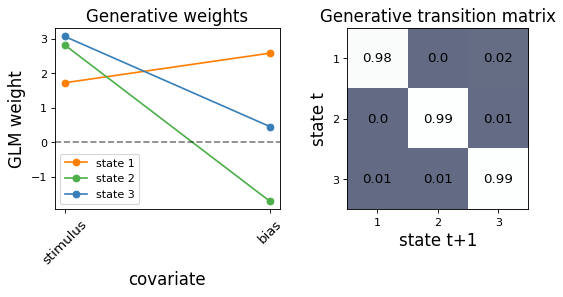

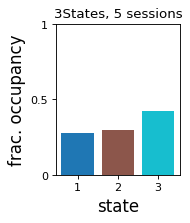

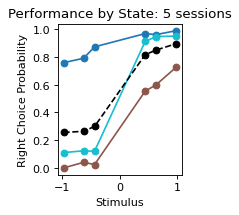

[   3    6    7 ... 2492 2495 2497]
1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

[   0    1    2 ... 2496 2498 2499]
1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

[   0    2    3 ... 2494 2495 2497]
2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

[   1    7    8 ... 2496 2498 2499]
2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

[   0    1    5 ... 2496 2497 2498]
3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

[   2    3    4 ... 2492 2495 2499]
3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

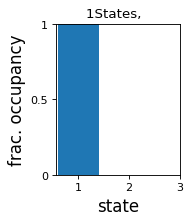

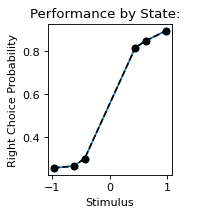

  0%|          | 0/200 [00:00<?, ?it/s]

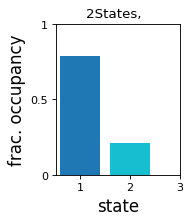

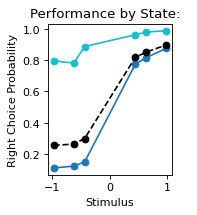

In [105]:
sub = 'BW016'
subjects = {'BW016': param_dict['BW016']}#available 'BW016','BW031', 'BW045'
stim_vals = [-.98,-.75,-.62,.62,.75,.98] #stimuli to use for generating synthetic data from ground truth model
true_glmhmm = makeModel(3, obs_dim, num_categories, input_dim,
                               param_dict[sub])
inpts, true_latents, true_choices = simulateData(true_glmhmm, 5, 
                                                         500, stim_vals)

inpts_ = inpts
true_latents_ = true_latents
true_choices_ = true_choices

##===== K-fold Cross-Validation =====##
nKfold = 2
max_states = 3
# Set the parameters of the GLM-HMM
num_states = 3        # number of discrete states for ground truth model
obs_dim = 1           # number of observed dimensions for ground truth model
num_categories = 2    # number of categories for output for ground truth model
input_dim = 2         # input dimensions for ground truth model
map_results, mle_results, models = modelSelectionCV(inpts_, true_choices_, max_states, nKfold, 
                                            obs_dim, input_dim, N_iters=2000, 
                                            TOL=10**-6, min_states=1)
map_mods, mle_mods = models[0], models[1]

title = ' '
plotModelBehavCV(inpts_, true_choices_, max_states, 1, num_categories, obs_dim,
                 input_dim, 'MAP', title)


In [77]:
len(data_sim[0][:1][0])
test_in = np.stack(data_sim[0][:2])
test_in.shape

(800, 2)

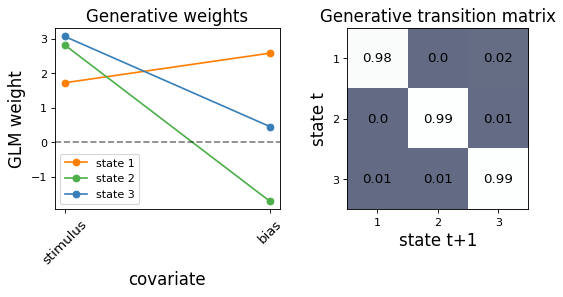

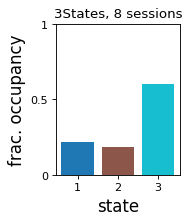

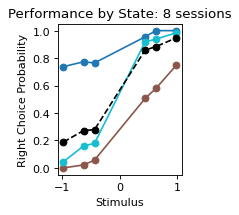

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [109]:
#MODEL SELECTION
#loop over many different sesion counts and plot L2 distance between the generative model
#parameters and the recovered parameters
num_sess_max = 8
nKfold = 5# np.min([num_sess,5]) # if there are more than 4 sessions, group sessions together to create 4 folds
max_states = 5 # largest number of states allowed in the model selection
min_states = 1
num_sess_min = 1#minimum number of sessions to test
num_trials_per_sess = 400

# Set the parameters of the GLM-HMM
num_states = 3        # number of discrete states for ground truth model
obs_dim = 1           # number of observed dimensions for ground truth model
num_categories = 2    # number of categories for output for ground truth model
input_dim = 2         # input dimensions for ground truth model
stim_vals = [-.98,-.75,-.62,.62,.75,.98] #stimuli to use for generating synthetic data from ground truth model
subjects = {'BW016': param_dict['BW016']}#available 'BW016','BW031', 'BW045'
#subjects = param_dict
n_subs = len(subjects.keys())#number of subjects included in original, real data

#create array to hold training results for all ground truth models, MAP
training_results_map = np.empty((n_subs, num_sess_max-num_sess_min, max_states, nKfold))
#create array to hold testing results for all ground truth models, MAP
testing_results_map = np.empty((n_subs, num_sess_max-num_sess_min, max_states, nKfold))

#create array to hold training results for all ground truth models, MLE
training_results_mle = np.empty((n_subs, num_sess_max-num_sess_min, max_states, nKfold))
#create array to hold testing results for all ground truth models, MLE
testing_results_mle = np.empty((n_subs, num_sess_max-num_sess_min, max_states, nKfold))

#array to hold BIC results
BIC_results = np.empty((n_subs, num_sess_max-num_sess_min, max_states))
#for each ground truth parameter set.. see how many sessions it takes to recover params
######SEPERATE OUT DATA GEN AND FIT######
for i, sub in enumerate(subjects.keys()):
    true_glmhmm = makeModel(num_states, obs_dim, num_categories, input_dim,
                                   subjects[sub])
    inpts, true_latents, true_choices = simulateData(true_glmhmm, num_sess_max, 
                                                 num_trials_per_sess, stim_vals)
    data_sim = [inpts, true_latents, true_choices]
    map_, mle_, BIC_ = modelSelection(data_sim, num_states, obs_dim, num_categories, 
                                      input_dim, num_sess_min, num_sess_max, num_trials_per_sess, 
                                      stim_vals, nKfold, max_states, min_states, plot=False)
    training_results_map[i, :, :, :] = map_[0]
    testing_results_map[i, :, :, :] = map_[1]
    training_results_mle[i, :, :, :] = mle_[0]
    testing_results_mle[i, :, :, :] = mle_[1]
            
    BIC_results[i, :, :] = BIC_
    


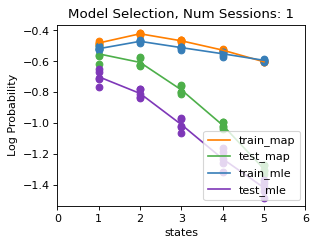

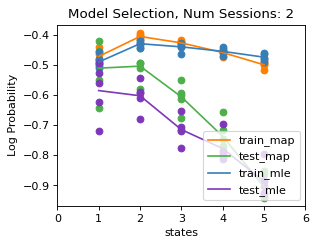

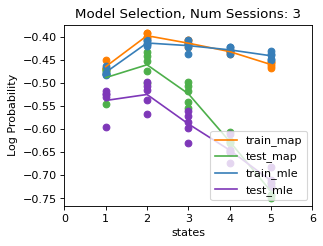

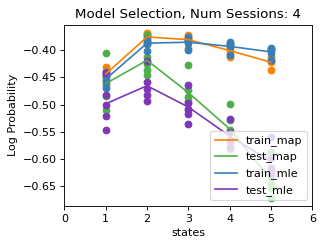

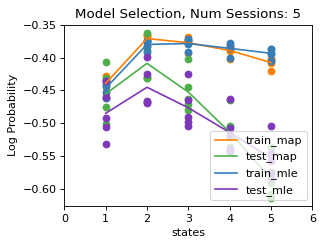

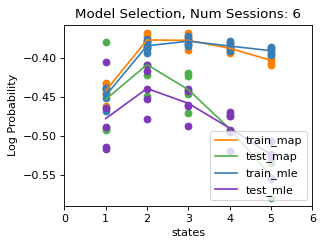

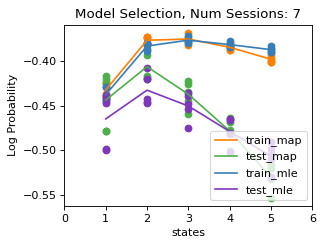

In [110]:
#plot results
for i in range(training_results_map.shape[1]):#for each tested session length
    train_av_map = np.mean(training_results_map[:,i,:,:], axis=0)#calculate average train results for each ground truth
    test_av_map = np.mean(testing_results_map[:,i,:,:], axis=0)#calculate average test results for each ground truth
    
    train_av_mle = np.mean(training_results_mle[:,i,:,:], axis=0)#calculate average train results for each ground truth
    test_av_mle = np.mean(testing_results_mle[:,i,:,:], axis=0)#calculate average test results for each ground truth
    
    cols = ['#ff7f00', '#4daf4a', '#377eb8', '#7E37B8']
    fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
    for iS, num_states in enumerate(range(1,max_states+1)):
        plt.plot((iS+1)*np.ones(nKfold),train_av_map[iS,:], color=cols[0], marker='o',lw=0)
        plt.plot((iS+1)*np.ones(nKfold),test_av_map[iS,:], color=cols[1], marker='o',lw=0)

        plt.plot((iS+1)*np.ones(nKfold),train_av_mle[iS,:], color=cols[2], marker='o',lw=0)
        plt.plot((iS+1)*np.ones(nKfold),test_av_mle[iS,:], color=cols[3], marker='o',lw=0)

    plt.plot(range(1,max_states+1),np.mean(train_av_map,1), label="train_map", color=cols[0])
    plt.plot(range(1,max_states+1),np.mean(test_av_map,1), label="test_map", color=cols[1])
    
    plt.plot(range(1,max_states+1),np.mean(train_av_mle,1), label="train_mle", color=cols[2])
    plt.plot(range(1,max_states+1),np.mean(test_av_mle,1), label="test_mle", color=cols[3])

    # plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
    plt.title('Model Selection, Num Sessions: ' + str(i + 1))
    plt.legend(loc="lower right")
    plt.xlabel("states")
    plt.xlim(0, max_states+1)
    plt.ylabel("Log Probability")
    plt.show()

<Figure size 320x240 with 0 Axes>

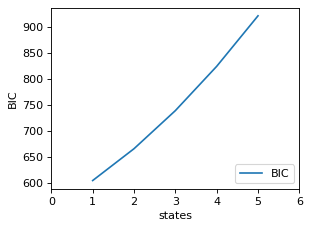

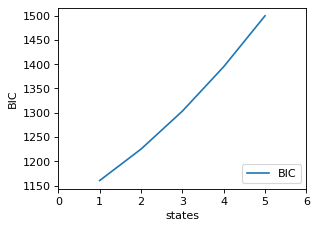

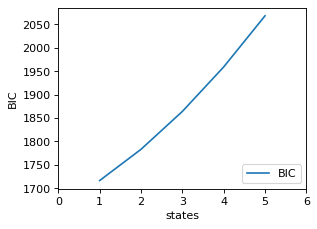

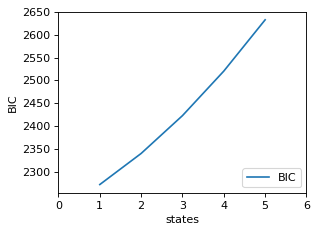

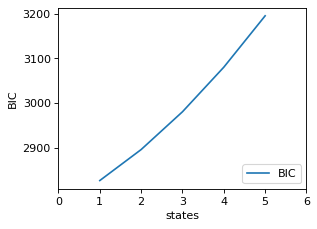

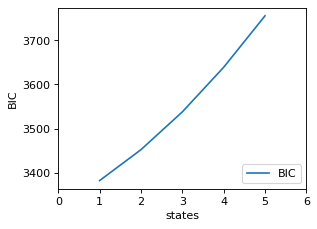

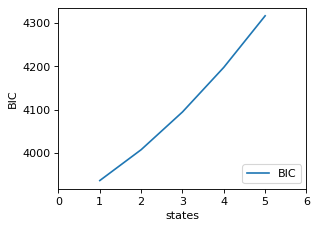

In [100]:
#plot results
subjects = BIC_results.shape[0]
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(BIC_results.shape[1]):#for each tested session length
    BIC_av = np.mean(BIC_results[:, i, :], axis=0)#calculate average train results for each ground truth
    
#     for sub in range(subjects):
#         for iS, num_states in enumerate(range(1,max_states+1)):
#             plt.plot((iS+1)*np.ones(subjects),BIC_results[sub, iS,:], color=cols[0], marker='o',lw=0)

    fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(range(1,max_states+1),BIC_av, label="BIC")
    plt.legend(loc="lower right")
    plt.xlabel("states")
    plt.xlim(0, max_states+1)
    plt.ylabel("BIC")
    plt.show()

In [99]:
#FIT WITH INCREASING SESSION COUNT
training_results_map

array([[[[-0.46894204, -0.4499818 , -0.46973763, -0.45362351,
          -0.44818535],
         [-0.36592145, -0.36480977, -0.38980993, -0.40056995,
          -0.38200046],
         [-0.42953311, -0.43762433, -0.45209093, -0.42468906,
          -0.38676571],
         [-0.48009117, -0.49400073, -0.48437448, -0.49243425,
          -0.49637282],
         [-0.55399042, -0.55792392, -0.60606935, -0.56333841,
          -0.56533806]],

        [[-0.42811154, -0.44986269, -0.45479826, -0.45293165,
          -0.44721433],
         [-0.36949513, -0.38397666, -0.36965311, -0.40155624,
          -0.36502198],
         [-0.38120226, -0.39907959, -0.4174731 , -0.40349399,
          -0.41490044],
         [-0.43673591, -0.43428156, -0.41454449, -0.44219272,
          -0.44561531],
         [-0.47301185, -0.46491704, -0.48410101, -0.47629375,
          -0.4783971 ]],

        [[-0.43121469, -0.44755482, -0.4396755 , -0.4384309 ,
          -0.43009274],
         [-0.36875109, -0.3615685 , -0.37941094, -

In [7]:
#PERFORM FOR NO CHOICE/3 EMISSION MODEL

500

In [35]:
#use same ground truth model used by Zoe Ashwood.
# Set the parameters of the GLM-HMM
# num_states = 3        # number of discrete states
# obs_dim = 1           # number of observed dimensions
# num_categories = 2    # number of categories for output
# input_dim = 2         # input dimensions

# # Make a GLM-HMM
# true_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
#                    observation_kwargs=dict(C=num_categories), transitions="standard")

# gen_weights = np.array([[[6, 1]], [[2, -3]], [[2, 3]]])
# gen_log_trans_mat = np.log(np.array([[0.98, 0.01, 0.01], [0.05, 0.92, 0.03], [0.02, 0.03, 0.94]]))
# true_glmhmm.observations.params = gen_weights
# true_glmhmm.transitions.params = gen_log_trans_mat

(1, 3, 3)

Figure out why log likelihood is different for parameter recovery model selection and the model selection done on a single subject HMM-GLM model.

/Users/danielburnham/opt/anaconda3/envs/uobrainflex/lib/python3.6/site-packages/hdmf/spec/namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.2.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/Users/danielburnham/opt/anaconda3/envs/uobrainflex/lib/python3.6/site-packages/hdmf/spec/namespace.py:533: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.3.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


  0%|          | 0/200 [00:00<?, ?it/s]

kfold 0 TRAIN: 4 TEST: 1
kfold 1 TRAIN: 4 TEST: 1
kfold 2 TRAIN: 4 TEST: 1
kfold 3 TRAIN: 4 TEST: 1
kfold 4 TRAIN: 4 TEST: 1
1


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

2


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

2


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

2


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

2


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

2


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

3


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

3


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

3


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

3


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

3


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

5


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

5


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

5


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

5


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

5


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

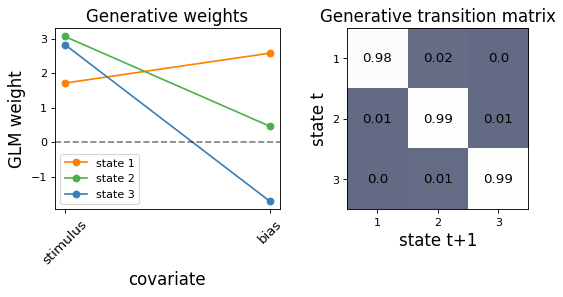

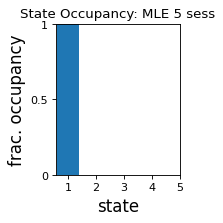

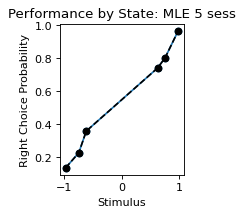

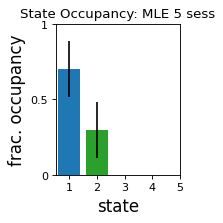

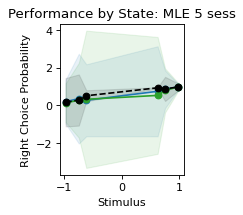

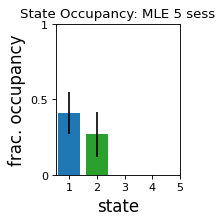

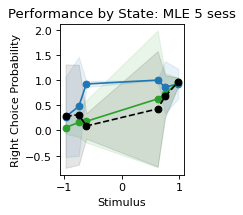

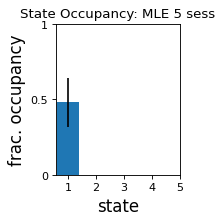

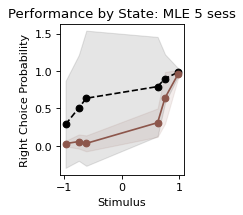

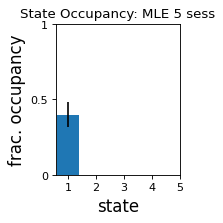

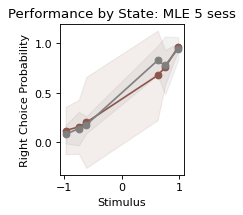

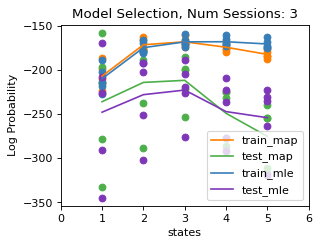

In [86]:
#do fit with standard parameters
subject_dict = {'BW016': (20210421,20210428)}
# Set the parameters of the GLM-HMM
num_states = 3        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions
fit_sub_ll, model_dict, param_dict, data = fitModel(subject_dict, num_states, 
                                                    obs_dim, num_categories, input_dim)

#set model selection parameters
max_states = 5
min_states = 1
nKfold = 5
#perform model selection
n_subs = len(subject_dict.keys())

map_results, mle_results, models = modelSelectionCV(data['BW016']['inpts'], 
                                                    data['BW016']['true_choices'], 
                                                    max_states, nKfold, obs_dim, 
                                                    input_dim, N_iters=1000, TOL=10**-6, 
                                                    min_states=min_states)
#set plotting parameters
stim_vals = [-.98,-.75,-.62,.62,.75,.98] #stimuli to use for generating synthetic data from ground truth model
num_sess = len(data['BW016']['inpts']) 
map_mods, mle_mods = models[0], models[1]
title = 'MAP ' + str(num_sess) + ' sess'
plotModelBehavCV(map_mods, map_mods['inpts'], map_mods['true_choices'], 
                 max_states, min_states, nKfold, stim_vals, num_categories, obs_dim, input_dim, title)
title = 'MLE ' + str(num_sess) + ' sess'
plotModelBehavCV(mle_mods, mle_mods['inpts'], mle_mods['true_choices'], 
                 max_states, min_states, nKfold, stim_vals, num_categories, obs_dim, input_dim, title)

training_map = map_results[0]
testing_map = map_results[1]
training_mle = mle_results[0]
testing_mle = mle_results[1]

#plot results
cols = ['#ff7f00', '#4daf4a', '#377eb8', '#7E37B8']
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
for iS, num_states in enumerate(range(1,max_states+1)):
    plt.plot((iS+1)*np.ones(nKfold),training_map[iS,:], color=cols[0], marker='o',lw=0)
    plt.plot((iS+1)*np.ones(nKfold),testing_map[iS,:], color=cols[1], marker='o',lw=0)

    plt.plot((iS+1)*np.ones(nKfold),training_mle[iS,:], color=cols[2], marker='o',lw=0)
    plt.plot((iS+1)*np.ones(nKfold),testing_mle[iS,:], color=cols[3], marker='o',lw=0)

plt.plot(range(1,max_states+1),np.mean(training_map,1), label="train_map", color=cols[0])
plt.plot(range(1,max_states+1),np.mean(testing_map,1), label="test_map", color=cols[1])

plt.plot(range(1,max_states+1),np.mean(training_mle,1), label="train_mle", color=cols[2])
plt.plot(range(1,max_states+1),np.mean(testing_mle,1), label="test_mle", color=cols[3])

# plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
plt.title('Model Selection, Num Sessions: ' + str(num_sess))
plt.legend(loc="lower right")
plt.xlabel("states")
plt.xlim(0, max_states+1)
plt.ylabel("Log Probability")
plt.show()

In [67]:
ll_heldout_map_m

array([[-0.40961309, -0.47437059, -0.42043653, -0.42153189, -0.44651983],
       [-0.38086517, -0.39289967, -0.38996153, -0.41523699, -0.40617835],
       [-0.47464981, -0.43731593, -0.4539955 , -0.38835061, -0.44956001],
       [-0.49970669, -0.45613123, -0.5419778 , -0.48757982, -0.52574877],
       [-0.54662199, -0.53811009, -0.56306499, -0.54272079, -0.58379664]])

In [100]:
param_dict['BW016']

{'GLM_weights': array([[[-2.82797271,  1.71850342]],
 
        [[-3.0627026 , -0.46036163]],
 
        [[-1.71875305, -2.58046436]]]),
 'HMM_probs': array([[-0.01379418, -4.61640722, -5.56980537],
        [-4.9918858 , -0.01383383, -4.96962746],
        [-5.79548354, -3.92336801, -0.02307995]])}